In [1]:
import io
from collections import namedtuple
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
from google.protobuf.json_format import MessageToJson
from google.protobuf.json_format import Parse
from google.protobuf import json_format
import os
import sys
sys.path.append("..")
from models.bounding_box import FeatureType, Point, BoundingBox, DSU
from utils.cv_preprocess import *

from utils.file_utils import prepare_image_local, prepare_image_web, load_counter, save_counter, save_json

from utils.nlp_preprocess import *
from models.word_unit import WordUnit
from models.dish_segmenter import Dish
from IPython.display import display



In [2]:
import spacy
from models.dish_segmenter import Dish
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import json
from models.word_unit import WordUnit
import spacy
from spacy.language import Language
from typing import Dict, List, Set, Tuple
from collections import defaultdict

In [3]:
load_spacy_models()

In [4]:
filein = '../downloaded_menu/english_start/15._The_Duck_&_Rice_1_page_1.png'
base_name = os.path.basename(filein)
file_name_without_extension = os.path.splitext(base_name)[0]


raw_ocr_directory = '../downloaded_menu/raw_ocr/'
raw_ocr_filename = file_name_without_extension + "_raw_annotation.json"
raw_ocr_path = os.path.join(raw_ocr_directory, raw_ocr_filename)

preprocessed_ocr_directory = '../downloaded_menu/prep_ocr_v2/'
preprocessed_ocr_filename = file_name_without_extension + "_prep_ocr.json"
preprocessed_ocr_path = os.path.join(preprocessed_ocr_directory, preprocessed_ocr_filename)

In [5]:
# Open the file for reading
with open(raw_ocr_path, 'r') as file:
    document = json.load(file)

In [6]:
image = Image.open(filein)

In [7]:
from statistics import mean

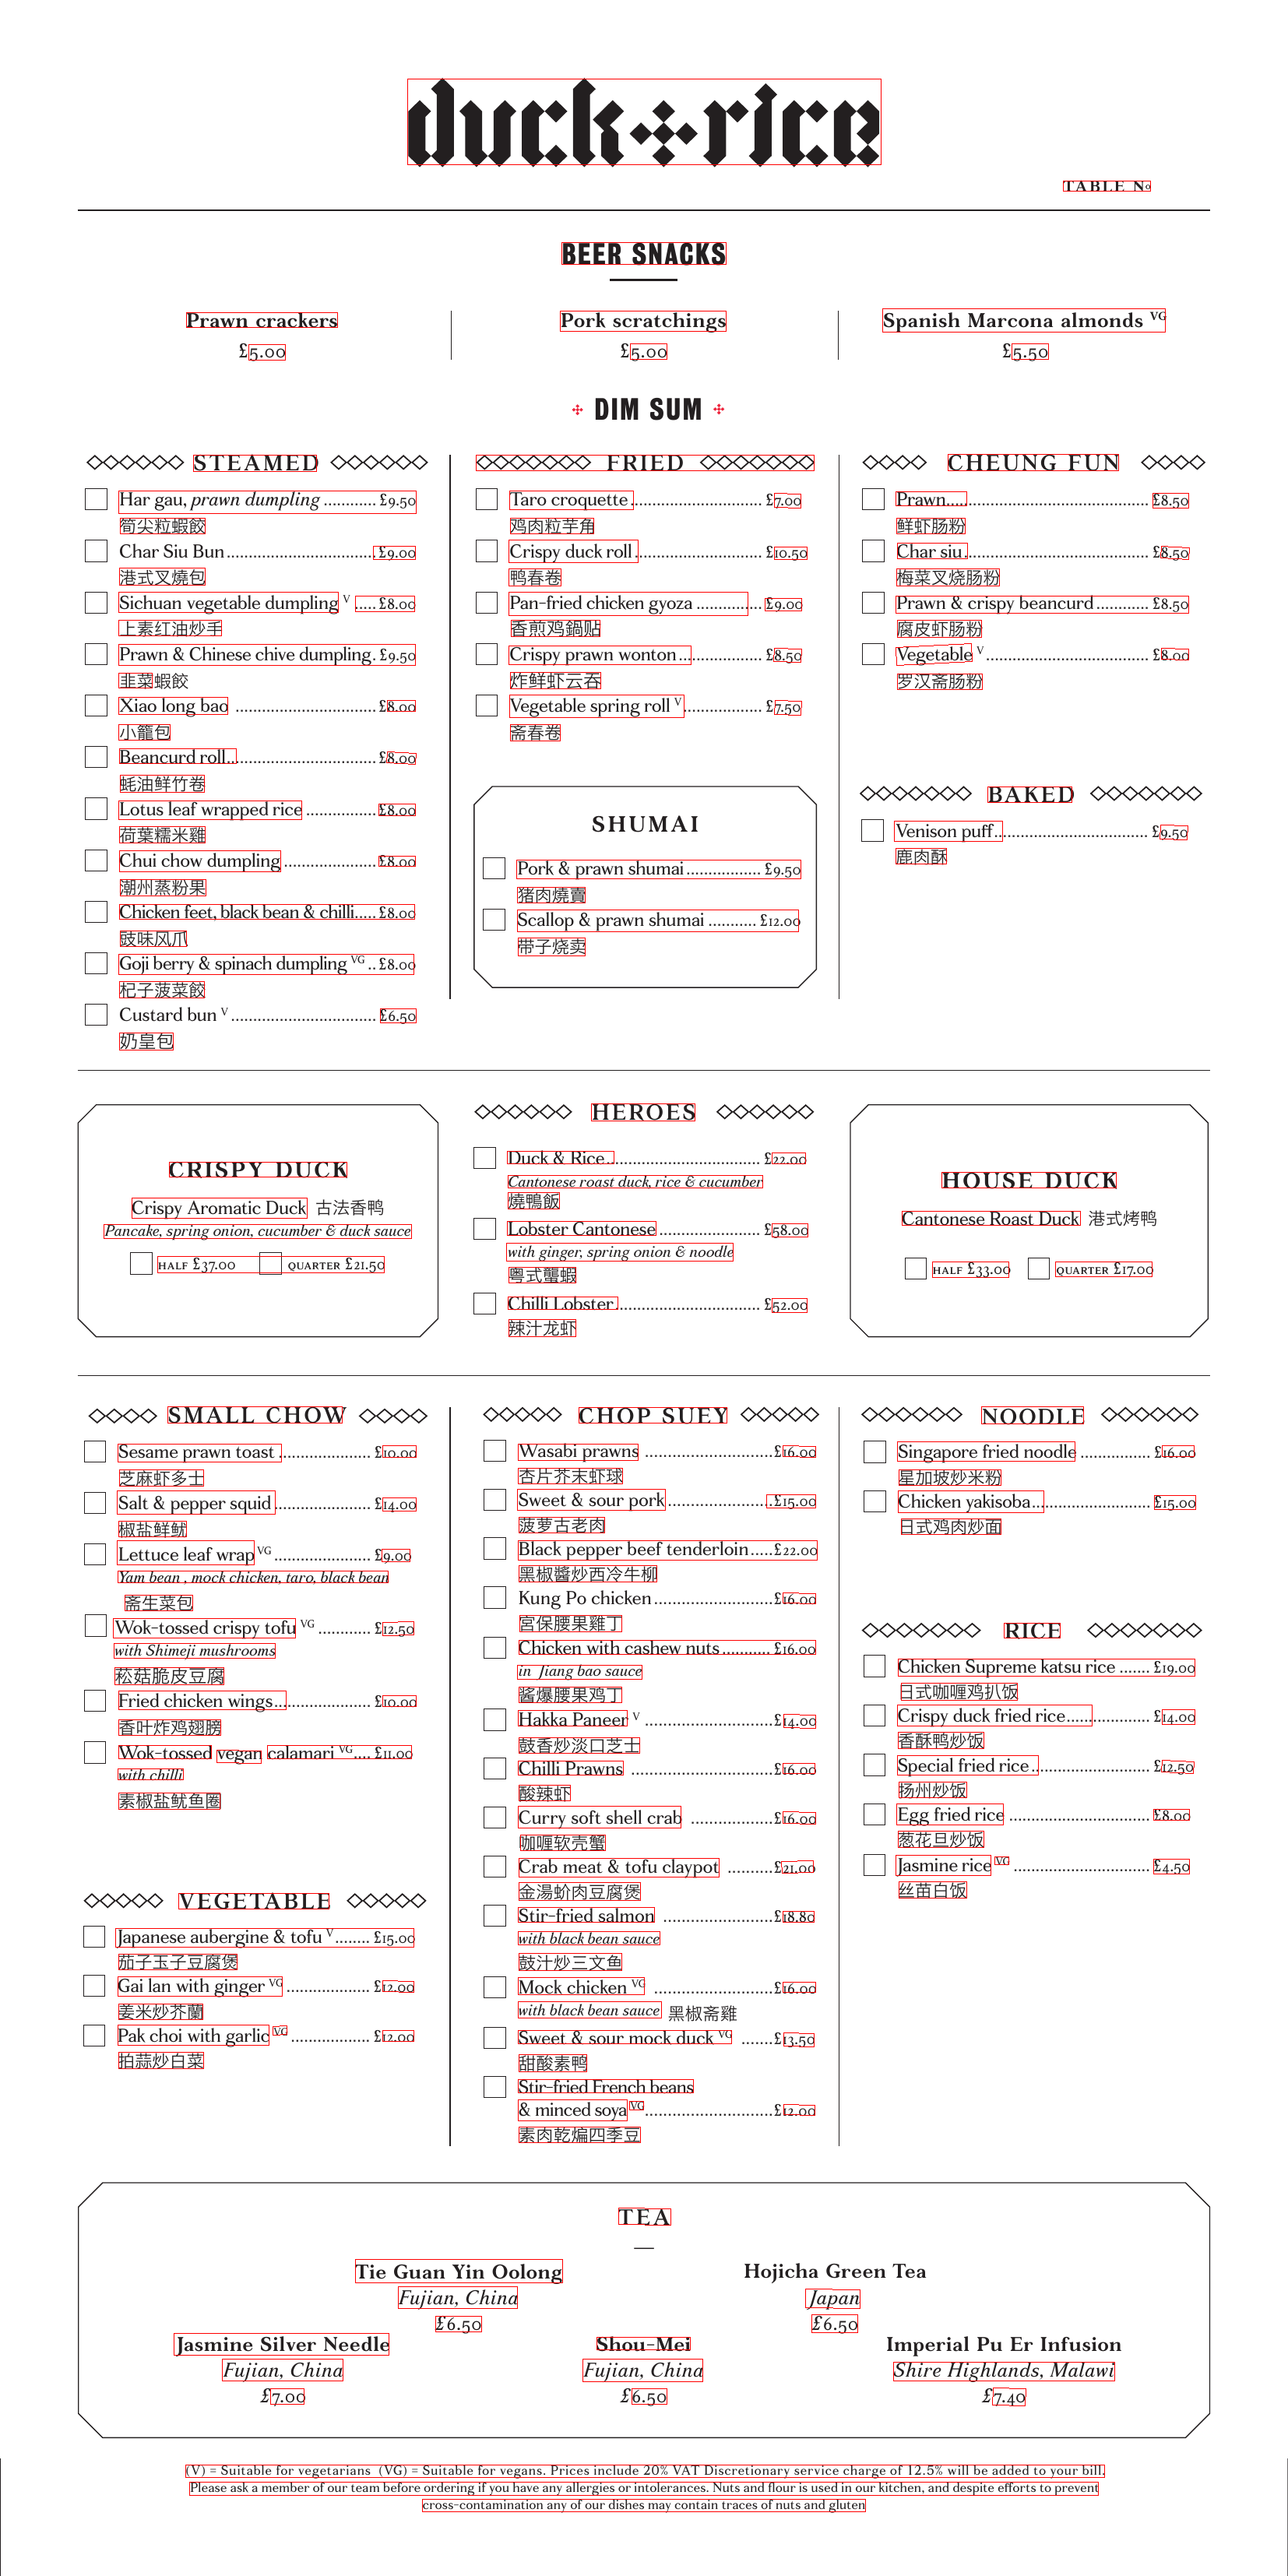

In [8]:
image = Image.open(filein)

feature = FeatureType.PARA

bounds = []

word_level_bounds = []

split_bounds = []

accept_languages = ['zh', 'en']

# Collect specified feature bounds by enumerating all document features

paragraph_bounds = []
for page in document['pages']:
    for block in page['blocks']:
        paragraph_word = []
        
        for paragraph in block['paragraphs']:
            words = []
            stored_y_min = []
            stored_height = []
            temp_bbox = None
            for word in paragraph['words']:
                current_word_lang = ''
                if 'property' in word and 'detectedLanguages' in word['property']:
                    if len(word['property']['detectedLanguages']) > 0 and 'languageCode' in word['property']['detectedLanguages'][0]:

                        current_word_lang = word['property']['detectedLanguages'][0]['languageCode']
                        if current_word_lang not in accept_languages:
                            continue
                symbols_data = [symbol['text'] for symbol in word['symbols'] if symbol['confidence'] > 0.8]
                
                # Extracting the text and confidence values
                symbols_text = ''.join(symbols_data)
                
                if symbols_text:
                    # Get the bounding box vertices of the first symbol as the word's bounding box
                    word_bbox = word['boundingBox']['vertices']
                    if 'y' not in word_bbox[0]:
                        break
                    word_top_left_y = word_bbox[0]['y']
                    stored_y_min_avg = mean(stored_y_min) if len(stored_y_min) >= 1 else 0
                    stored_height_avg = mean(stored_height) if len(stored_height) >= 1 else 0
                    
                    
                    # If we have no stored height yet, or the y-coordinate has changed significantly
                    if stored_height_avg != 0 and word_top_left_y > (0.75 * stored_height_avg + stored_y_min_avg):
                        # print(
                        #     "symbols_text:", symbols_text, "\n"
                        #     "stored_height_avg:", stored_height_avg, "\n"
                        #     "stored_y_min_avg:", stored_y_min_avg, "\n"
                        #     "word_top_left_y:", word_top_left_y, "\n"
                        #     "avg_top_left:", 0.75 * stored_height_avg + stored_y_min_avg, "\n"
                        #     "left:", word_top_left_y, "\n"
                        #     "right:", 0.75 * stored_height_avg + stored_y_min_avg, "\n"
                        #     "condition:", word_top_left_y > 0.75 * stored_height_avg + stored_y_min_avg
                        # )
                        # print()
                        # Save the previous paragraph

                        bounds.append(temp_bbox)
                        stored_height = []
                        stored_y_min = []
                        temp_bbox = None
                    
                    stored_height.append(word_bbox[2]['y'] - word_bbox[0]['y'])
                    stored_y_min.append(word_bbox[0]['y'])
                    if temp_bbox:
                        temp_bbox.merge(BoundingBox(word['boundingBox']['vertices'], [symbols_text]))
                    else:
                        temp_bbox = BoundingBox(word['boundingBox']['vertices'], [symbols_text])
                    # temp_bbox.append(BoundingBox(word['boundingBox']['vertices'], symbols_text))
                    
            

                words.append(symbols_text)   
                word_level_bounds.append(BoundingBox(word['boundingBox']['vertices'], symbols_text))
                
                if feature == FeatureType.WORD:
                    bounds.append(BoundingBox(word['boundingBox']['vertices'], symbols_text))
            
            if feature == FeatureType.PARA and temp_bbox:
                bounds.append(temp_bbox)   
                    
            
            
            # paragraph_bounds.append(BoundingBox(paragraph['boundingBox']['vertices'], words))
            paragraph_word.extend(words)
        
            # if feature == FeatureType.PARA:
            #     bounds.append(BoundingBox(paragraph['boundingBox']['vertices'], words))
        

        if feature == FeatureType.BLOCK:
            bounds.append(BoundingBox(block['boundingBox']['vertices'], paragraph_word))

draw_boxes(image, bounds, "red")
# plt.figure(figsize=(10, 10))
display(image)

In [9]:
price_bounds = []
for n in bounds:
    if "£" in n.text or "时价" in n.text:
        n_concat = "".join(n.text)
        price_bounds.append(n)
    else:
        n_concat = " ".join(n.text)
        if re.match(r'^[\d.]+$', n_concat):
            price_bounds.append(n)
    

In [10]:
for n in price_bounds:
    print(n.text, n.y_min, n.x_min)

['5.00'] 442 319
['Chicken', 'feet', ',', 'black', 'bean', '&', 'chilli', '....', '£', '8.0'] 1161 153
['Goji', 'berry', '&', 'spinach', 'dumpling', '.', '£', '8.00'] 1225 152
['.', '£', '9.00'] 701 479
['..', '£', '8.00'] 765 456
['8.00'] 899 497
['8.00'] 965 496
['£', '8.00'] 1032 486
['£', '8.00'] 1099 486
['9.00'] 1989 490
['£', '6.50'] 1295 488
['10.00'] 1856 491
['14.00'] 1923 491
['12.50'] 2082 491
['10.00'] 2177 491
['12.00'] 2543 491
['12.00'] 2607 491
['7.00'] 3067 347
['5.00'] 441 809
['£', '6.50'] 2974 559
['7.00'] 633 994
['10.50'] 702 994
['£', '9.00'] 768 982
['6.50'] 3067 811
['8.50'] 832 993
['7.50'] 899 994
['22.00'] 1480 991
['58.00'] 1571 991
['52.00'] 1667 991
['16.00'] 1856 1005
['16.00'] 2045 1005
['14.00'] 2201 1006
['16.00'] 2264 1005
['16.00'] 2326 1005
['21.00'] 2389 1003
['18.80'] 2454 1005
['16.00'] 2545 1005
['13.50'] 2610 1006
['12.00'] 2702 1006
['5.50'] 441 1299
['£', '8.50'] 633 1480
['9.50'] 1059 1489
['£', '6.50'] 2972 1042
['8.50'] 701 1490
['8.00']

In [11]:
import re

note_keywords = set(['gratuity', 'bill', 'subject to change', 'notice'])  # Using a set for efficiency


def preprocess_dish_text(string_list):
    preprocessed_items = []
    for item in string_list:
        # Replace '&' with 'and' and split on hyphens
        sub_items = item.replace('&', 'and').split('-')
        for sub_item in sub_items:
            # Remove unwanted symbols except for apostrophes and word characters
            cleaned_sub_item = re.sub(r"[^\w\s']", '', sub_item)  # Keeps word characters, whitespace, and apostrophes
            if any(note_keyword in cleaned_sub_item.lower() for note_keyword in note_keywords):
                # Add unique words from this sentence to the note_keywords list
                words = set(cleaned_sub_item.lower().split())
                note_keywords.update(words)
                return []
            # Check if the remaining string is a number or a price (like '10.80'), if not, keep it
            if not re.match(r'^\d+\.?\d*$', cleaned_sub_item) and cleaned_sub_item.strip():
                preprocessed_items.append(cleaned_sub_item)
    return preprocessed_items

In [12]:
def split_chinese_english(words):
    chinese_words = []
    english_words = []

    for word in words:
        if is_chinese(word):
            chinese_words.append(word)
        elif is_english(word):
            english_words.append(word)

    return chinese_words, english_words


In [13]:
import copy

In [14]:
chinese_bbox = []
english_bbox = []

filtered_bounds = []  # List to store bboxes that are not empty after preprocessing


for bbox in bounds:
    cleaned = preprocess_dish_text(bbox.text)
    bbox.text = cleaned
    
    if cleaned == []:
        # remove this bbox from bounds
        continue
    is_chinese_flag = all ([is_chinese(word) for word in cleaned])
    is_english_flag = all ([is_english(word) for word in cleaned])
    
    if is_chinese_flag:
        chinese_bbox.append(bbox)
        filtered_bounds.append(bbox)
    elif is_english_flag:
        english_bbox.append(bbox)
        filtered_bounds.append(bbox)
        


    if not is_chinese_flag and not is_english_flag:
        chinese_words, english_words = split_chinese_english(cleaned)


        sep_chinese_bbox = copy.deepcopy(bbox)
        sep_english_bbox = copy.deepcopy(bbox)

        sep_chinese_bbox.text = chinese_words
        sep_english_bbox.text = english_words
        filtered_bounds.append(sep_chinese_bbox)
        filtered_bounds.append(sep_english_bbox)
        
        
        chinese_bbox.append(sep_chinese_bbox)
        # print(sep_chinese_bbox.text)
        english_bbox.append(sep_english_bbox)




In [15]:
load_spacy_models()

In [16]:
from copy import deepcopy

In [17]:
def extend_bounding_boxes(bounding_boxes, container_width, container_height, extend_directions=[]):
    # Sort bounding boxes by their top-left corner (y_min, then x_min)
    sorted_bounding_boxes = sorted(deepcopy(bounding_boxes), key=lambda bbox: (bbox.y_min, bbox.x_min))

    for i, box in enumerate(sorted_bounding_boxes):
        x_min, x_max, y_min, y_max = box.x_min, box.x_max, box.y_min, box.y_max

        if ExtendDirection.LEFT in extend_directions:
            # Extend to the left
            left_candidates = [b.x_max for j, b in enumerate(sorted_bounding_boxes) if j != i and b.y_min <= y_max and b.y_max >= y_min and x_min > b.x_max]
            new_x_min = max(left_candidates + [0]) if left_candidates else 0
            x_min = new_x_min

        if ExtendDirection.TOP in extend_directions:
            # Extend upwards
            top_candidates = [b.y_max for j, b in enumerate(sorted_bounding_boxes) if j != i and b.x_min <= x_max and b.x_max >= x_min and y_min > b.y_max]
            new_y_min = max(top_candidates + [0]) if top_candidates else 0
            y_min = new_y_min

        if ExtendDirection.RIGHT in extend_directions:
            # Extend to the right
            right_candidates = [b.x_min for j, b in enumerate(sorted_bounding_boxes) if j != i and b.y_min <= y_max and b.y_max >= y_min and x_max < b.x_min]
            new_x_max = min(right_candidates + [container_width]) if right_candidates else container_width
            x_max = new_x_max

        if ExtendDirection.BOTTOM in extend_directions:
            # Extend downwards
            bottom_candidates = [b.y_min for j, b in enumerate(sorted_bounding_boxes) if j != i and b.x_min <= x_max and b.x_max >= x_min and y_max < b.y_min]
            new_y_max = min(bottom_candidates + [container_height]) if bottom_candidates else container_height
            y_max = new_y_max

        # Update the bounding box
        box.x_min, box.x_max, box.y_min, box.y_max = x_min, x_max, y_min, y_max

    return sorted_bounding_boxes





container_width, container_height = image.size

extended_boxes = extend_bounding_boxes(price_bounds, container_width, container_height, extend_directions=[ExtendDirection.LEFT, ExtendDirection.BOTTOM])
print("Extended bounding boxes:", extended_boxes)


Extended bounding boxes: [<models.bounding_box.BoundingBox object at 0x00000233B4BECE80>, <models.bounding_box.BoundingBox object at 0x00000233B4BFC6A0>, <models.bounding_box.BoundingBox object at 0x00000233B1717310>, <models.bounding_box.BoundingBox object at 0x00000233B4BEF400>, <models.bounding_box.BoundingBox object at 0x00000233B4BFC940>, <models.bounding_box.BoundingBox object at 0x00000233B4AEE340>, <models.bounding_box.BoundingBox object at 0x00000233B4C01160>, <models.bounding_box.BoundingBox object at 0x00000233B4BEF6A0>, <models.bounding_box.BoundingBox object at 0x00000233B4AEE5E0>, <models.bounding_box.BoundingBox object at 0x00000233B4BEF940>, <models.bounding_box.BoundingBox object at 0x00000233B4BEFE80>, <models.bounding_box.BoundingBox object at 0x00000233B4C01400>, <models.bounding_box.BoundingBox object at 0x00000233B4AEE880>, <models.bounding_box.BoundingBox object at 0x00000233B4BF4160>, <models.bounding_box.BoundingBox object at 0x00000233B4AEEB20>, <models.boundi

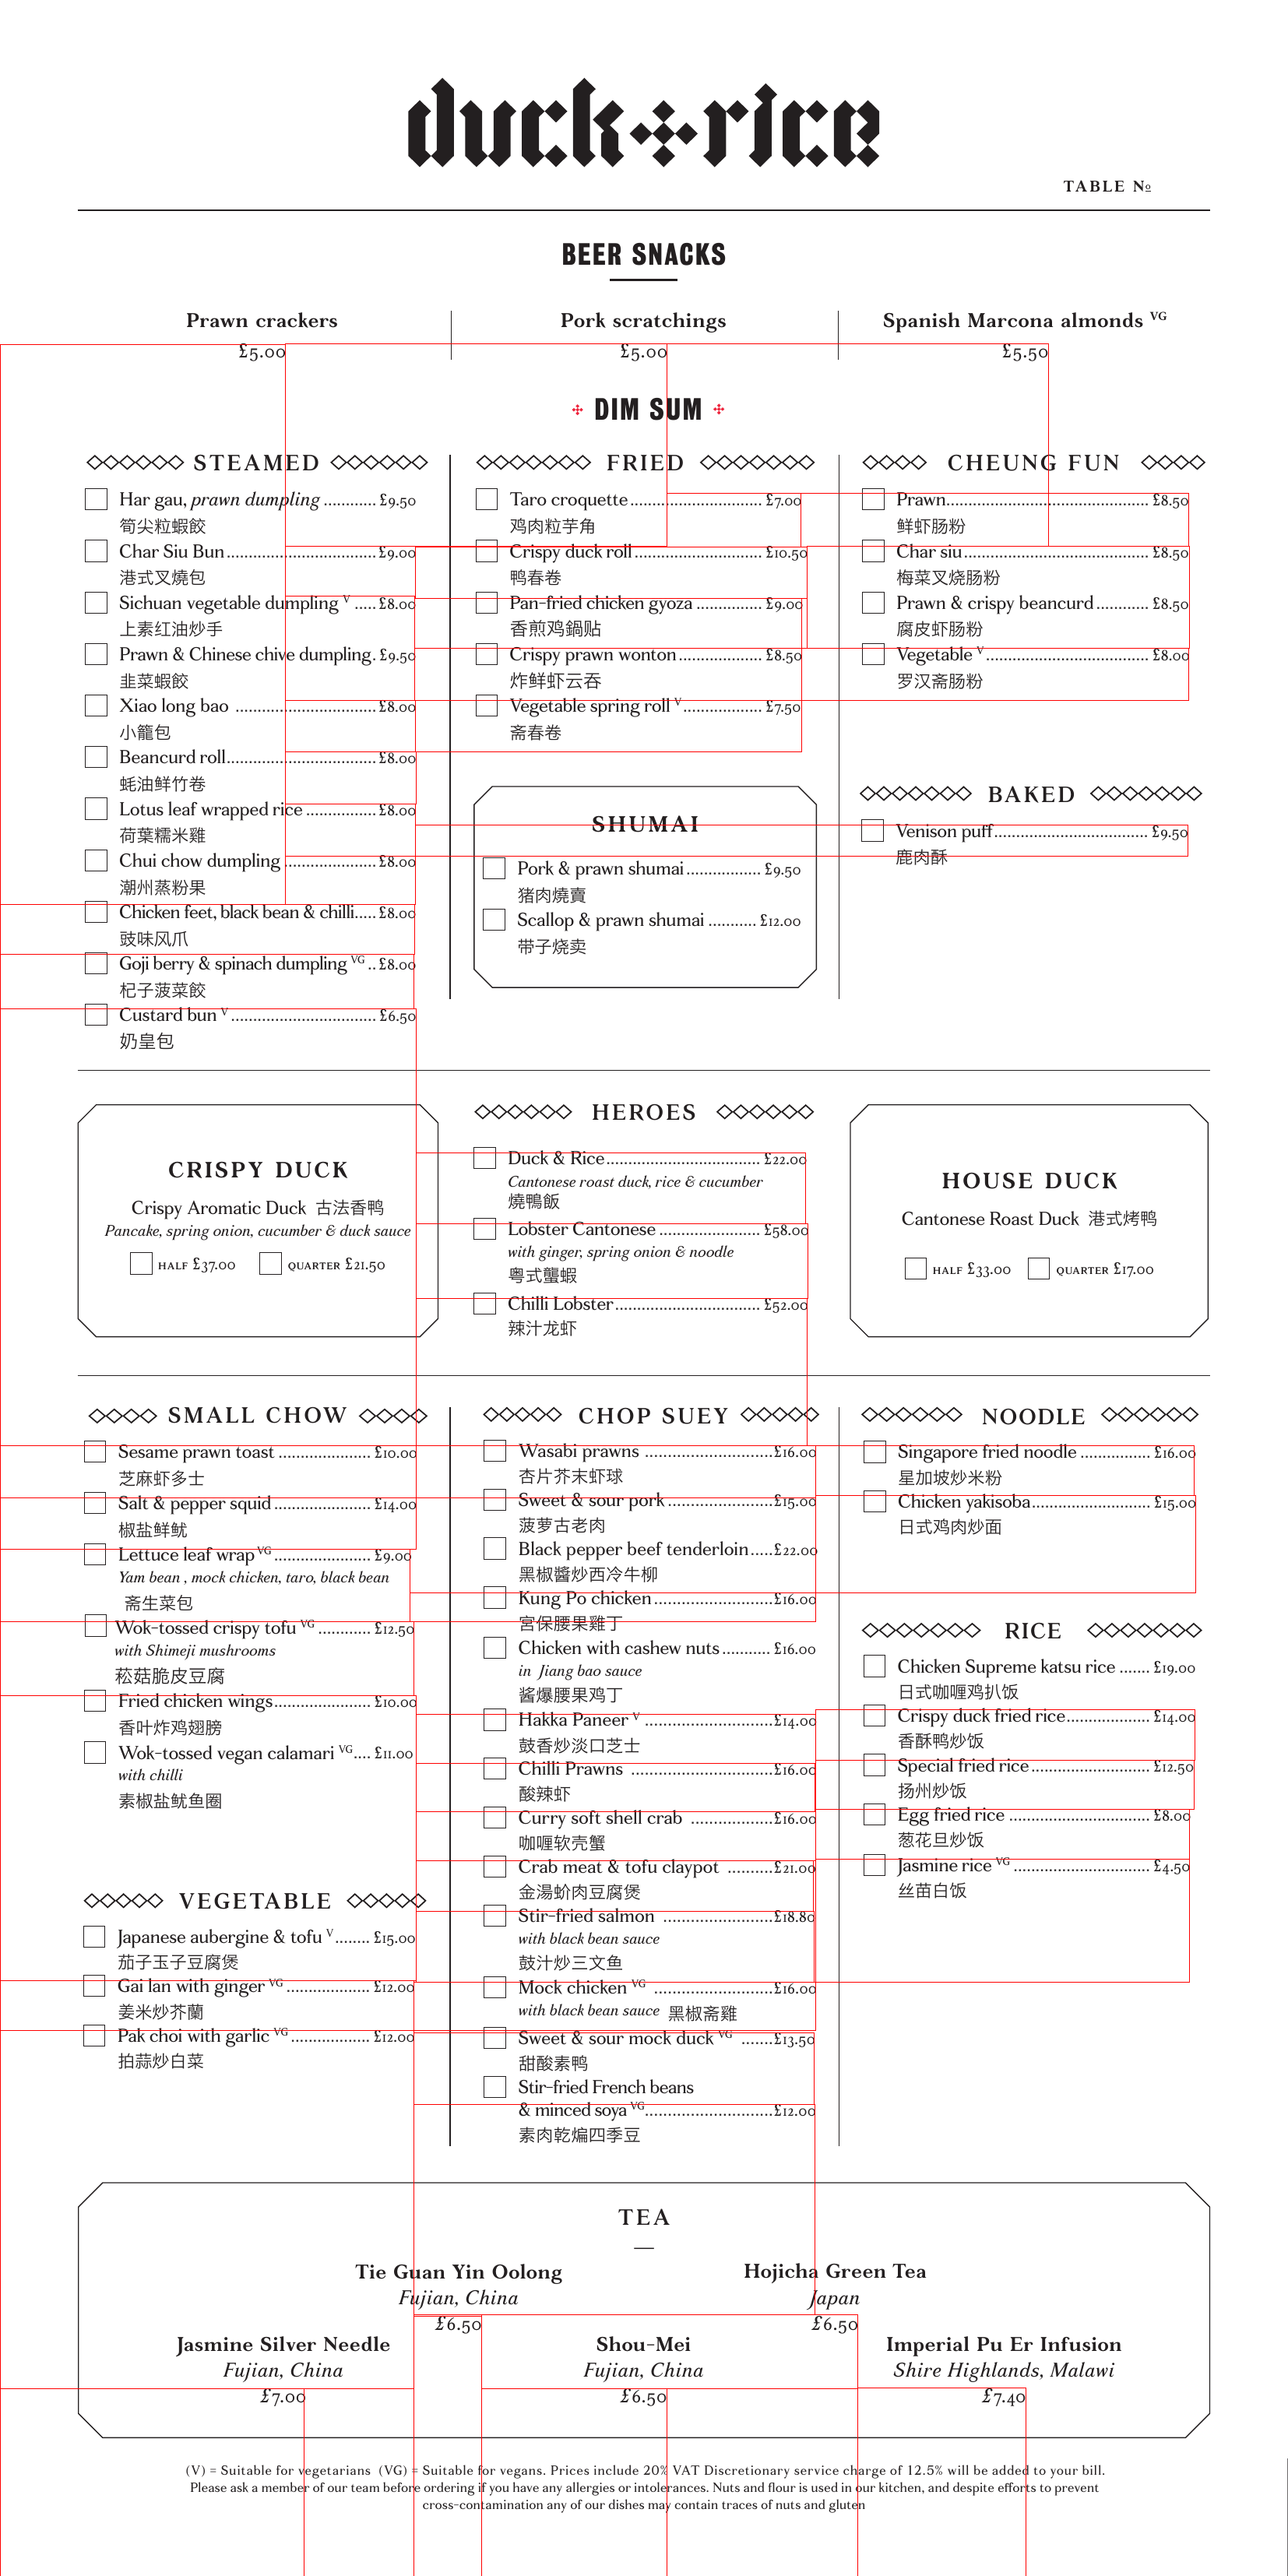

In [18]:
image2 = Image.open(filein)
draw_boxes_2_points(image2, extended_boxes, "red")
# plt.figure(figsize=(10, 10))
display(image2)

In [19]:
def calculate_overlap_area(box1, box2):
    # Determine the (x, y) coordinates of the intersection rectangle
    x_left = max(box1.x_min, box2.x_min)
    y_top = max(box1.y_min, box2.y_min)
    x_right = min(box1.x_max, box2.x_max)
    y_bottom = min(box1.y_max, box2.y_max)

    # Check if there is no overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of overlap
    return (x_right - x_left) * (y_bottom - y_top)

In [20]:
for n in filtered_bounds:
    print(n.text)

['Prawn', 'crackers']
['STEAMED']
['Har', 'gau', 'prawn', 'dumpling']
['筍尖', '粒', '蝦', '餃']
['港', '式', '叉燒包']
['Sichuan', 'vegetable', 'dumpling']
['CRISPY', 'DUCK']
['上', '素', '红', '油炒', '手']
['Prawn', 'and', 'Chinese', 'chive', 'dumpling']
['韭菜']
['Xiao', 'long', 'bao']
['小籠', '包']
['Beancurd', 'roll']
['SMALL', 'CHOW']
['Sesame', 'prawn', 'toast']
['芝麻', '虾', '多', '士']
['Salt', 'and', 'pepper', 'squid']
['蚝油', '鲜', '竹', '卷']
['Lotus', 'leaf', 'wrapped', 'rice']
['荷葉', '糯米', '雞']
['Chui', 'chow', 'dumpling']
['潮州', '蒸', '粉', '果']
['Chicken', 'feet', 'black', 'bean', 'and', 'chilli']
['豉', '味', '风', '爪']
['Goji', 'berry', 'and', 'spinach', 'dumpling']
['杞子', '菠菜', '餃']
['奶', '皇', '包']
['斋', '生菜', '包']
['Wok', 'tossed', 'crispy', 'tofu']
['with', 'Shimeji', 'mushrooms']
['duck', 'rice']
['菘', '菇', '脆皮', '豆腐']
['Fried', 'chicken', 'wings']
['香叶', '炸鸡', '翅膀']
['Wok', 'tossed']
['with', 'chilli']
['素', '椒盐', '鱿鱼', '圈']
['vegan']
['Crispy', 'Aromatic', 'Duck']
['Pancake', 'spring', 'onion'

In [21]:
grouped_list = []

sorted_bounding_boxes = sorted(filtered_bounds, key=lambda bbox: (bbox.y_min, bbox.x_min))
for extended_box in extended_boxes:
    current_list = []
    extended_area = (extended_box.x_max - extended_box.x_min) * (extended_box.y_max - extended_box.y_min)
    

    for bounding_box in sorted_bounding_boxes:
        bounding_area = (bounding_box.x_max - bounding_box.x_min) * (bounding_box.y_max - bounding_box.y_min)
        overlap_area = calculate_overlap_area(extended_box, bounding_box)

        if overlap_area >= 0.75 * bounding_area:
            
            current_list.append(bounding_box.text)
            # This bounding box is at least 50% covered
    if current_list:
        grouped_list.append(current_list)

In [22]:
for string_list in grouped_list:
    print(string_list)
    dish = segment_dish_text_list(string_list)
    print(dish)

[['Taro', 'croquette'], ['鸡肉', '粒', '芋', '角']]
Chinese Name: ['鸡肉', '粒', '芋', '角']
English Name: ['Taro', 'croquette']
Chinese Description: []
English Description: []
Raw text: None

[['筍尖', '粒', '蝦', '餃'], ['港', '式', '叉燒包'], ['Sichuan', 'vegetable', 'dumpling'], ['上', '素', '红', '油炒', '手'], ['韭菜'], ['Xiao', 'long', 'bao'], ['小籠', '包'], ['Beancurd', 'roll'], ['蚝油', '鲜', '竹', '卷'], ['Lotus', 'leaf', 'wrapped', 'rice'], ['荷葉', '糯米', '雞'], ['Chui', 'chow', 'dumpling'], ['潮州', '蒸', '粉', '果']]
Chinese Name: ['筍尖', '粒', '蝦', '餃']
English Name: ['Sichuan', 'vegetable', 'dumpling']
Chinese Description: [['港', '式', '叉燒包'], ['上', '素', '红', '油炒', '手'], ['韭菜'], ['小籠', '包'], ['蚝油', '鲜', '竹', '卷'], ['荷葉', '糯米', '雞'], ['潮州', '蒸', '粉', '果']]
English Description: [['Xiao', 'long', 'bao'], ['Beancurd', 'roll'], ['Lotus', 'leaf', 'wrapped', 'rice'], ['Chui', 'chow', 'dumpling']]
Raw text: None

[['Char', 'siu'], ['梅菜', '叉烧', '肠粉'], ['Prawn', 'and', 'crispy', 'beancur'], ['腐皮', '虾', '肠粉']]
Chinese Name: ['